## Figures for scaling experiment
This notebook generates supplemental figures based on results from our deep learning scaling experiment (associated pub: [TODO:TITLE]). The figure visualizes how well a ridge-regression analog fit through stochastic gradiant descent compares to an analytically fit ridge-regression linear model. 

### Input Data
This notebook takes as input the results generated from our scaling experiment. These can be generated by running the Snakemake files found in the directory of this notebook```workflow_sims/alphasimr_scaling```.

Specificaly, the notebook collects phenotype prediction statistics (validation set Pearson's r) from text files generates by ```Snakefile_gpatlas.smk``` which fits the linear model ```fit_linearSGD.py``` and ```../common_scripts/fit_rdge_cv.py```. The prediction statistics are written to text files in ```gplinear``` and ```linear_model```. These files will contain simulation run parameters in their names e.g. ```gplinear/qhaplo_16qtl_1000n_rep1_phenotype_correlations_untuned.csv```(ie., 16 QTLs, 1000 samples, replicate 1) which this notebook will extract and use when plotting results. 

Note, to generate these model outputs first you must generate simulated data by running the entire Snakemake pipeline. See repo README for more details. 

### Notebook workflow
- Harvest model performance outputs for linear and DL model
- Combine into one file for plotting
- Plot Pearson's r comparison

In [13]:
import pandas as pd
import glob
import re
import os

import matplotlib.pyplot as plt

In [14]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)qtl', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))

                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value

            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        #print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [15]:
rrBLUP = harvest_mod_outputs('./linear_model', 'qhaplo_*qtl_*n_rep*_scklrr_corr_summary.txt')
linear_df = harvest_mod_outputs('./gplinear', 'qhaplo_*qtl_*n_rep*_phenotype_correlations_untuned.csv')


In [16]:
rrBLUP.rename(columns={'pearson_corr_pheno_mean':'pearson_correlation'}, inplace=True)
rrBLUP.rename(columns={'trait':'trait_number'}, inplace=True)


In [17]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'rep'])

    return common_params


In [18]:
common_params = get_parameter_combinations(linear_df, rrBLUP)


In [19]:
def generate_comparison_df(df1, df2, common_params):
    """
    Generates paired comparison dataframe from two input dataframes that contain prediciton results from different models

    Args: The two dataframes to compare, and common param combinations
    Returns: Single dataframe with paired up outputs
    """
    comparison_data = []

    for _, row in common_params.iterrows():
        qtl = row['qtl_param']
        n = row['n_param']
        trait = row['trait_number']
        rep = row['rep']

        linear_row = df1[(df1['qtl_param'] == qtl) &
                            (df1['n_param'] == n) &
                            (df1['trait_number'] == trait) &
                            (df1['rep'] == rep)]

        neural_row = df2[(df2['qtl_param'] == qtl) &
                            (df2['n_param'] == n) &
                            (df2['trait_number'] == trait)&
                            (df2['rep'] == rep)]

        if not linear_row.empty and not neural_row.empty:
            comparison_data.append({
                'qtl_param': qtl,
                'n_param': n,
                'trait_number': trait,
                'rep': rep,
                'linear_correlation': linear_row['pearson_correlation'].values[0],
                'neural_correlation': neural_row['pearson_correlation'].values[0],
                'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
            })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df


In [20]:
comparison_df = generate_comparison_df(rrBLUP, linear_df, common_params)


### Supplemental figure

Pearson's r of a linear model fit analytically (x-axis) vs via SGD (y-axis), across phenotype genetic architectures (colours)

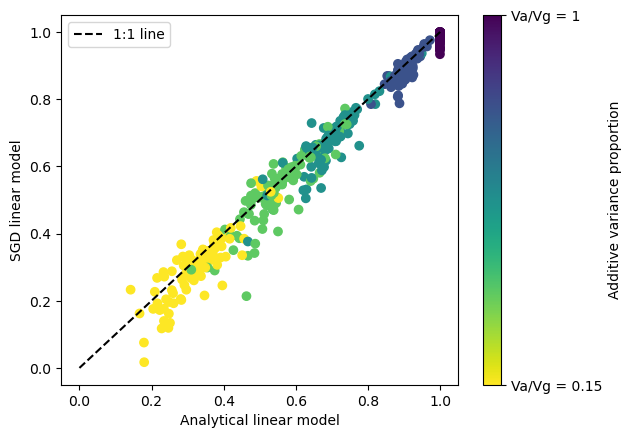

In [37]:
trait_data2 = comparison_df

# Create figure and axes
fig, ax = plt.subplots()

# Create the scatter plot
scatter = ax.scatter(trait_data2['linear_correlation'],
                     trait_data2['neural_correlation'],
                     c=trait_data2['trait_number'],
                     cmap='viridis')

# Add the 1:1 line
ax.plot([0, 1], [0, 1], 'k--', label='1:1 line')

# Add axis labels
ax.set_xlabel('Analytical linear model')
ax.set_ylabel('SGD linear model')
ax.legend()

# Get min and max trait numbers
min_trait = trait_data2['trait_number'].min()
max_trait = trait_data2['trait_number'].max()

# Add a colorbar with explicit tick positions
# Use 'extend' parameter to ensure colorbar covers the full range
cbar = fig.colorbar(scatter, ax=ax, ticks=[min_trait, max_trait])

# Set the labels
cbar.set_ticklabels(["Va/Vg = 1", "Va/Vg = 0.15"])

# Set the colorbar title
cbar.set_label('Additive variance proportion')

# Invert the colorbar axis - THIS IS THE KEY STEP
cbar.ax.invert_yaxis()
